In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

import glob

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

# Outlier analysis

In this notebook we specifically analyse the outliers, i.e. the events that QNet predicted with large distances compared to the catalog locations and those with low amplitudes in the predictions.

In [ ]:
# Functions to load model

def dice_coef_gaussian(y_true, y_pred, smooth=1):
  y_true = tf.dtypes.cast(y_true>0.1, tf.int32)
  y_true = tf.dtypes.cast(y_true, tf.float32)
  y_pred = tf.dtypes.cast(y_pred>0.1, tf.int32)
  y_pred = tf.dtypes.cast(y_pred, tf.float32)
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_coef(y_true, y_pred, smooth=1):
  y_true = tf.dtypes.cast(y_true, tf.float32)
  y_pred = tf.dtypes.cast(y_pred, tf.float32)
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

# Clip values in Gaussian above 0.1 to 1 and below 0.1 to 0
def iou_coef_gaussian(y_true, y_pred, smooth=1):
    y_true = tf.dtypes.cast(y_true>0.1, tf.int32)
    y_true = tf.dtypes.cast(y_true, tf.float32)
    y_pred = tf.dtypes.cast(y_pred>0.1, tf.int32)
    y_pred = tf.dtypes.cast(y_pred, tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
# functions to make predictions
# Functions to make predictions on days 5 and after

def normalize(data):
    data = data/np.max(np.abs(data))
    return data
    
def make_predictions(data_files, model, pd_dict_name, check_day, detection_threshold=0.6):

    '''

    pd = (data_files, model, pd_dict_name, detection_threshold=0.6)

    Runs model prediction for all data_files and returns file names of the detected events,
    list of detections (True/False) and a list of all the filenames.
    Additionally it generates pandas dataframe with information about the prediction for each event.

    Args:
        data_files: list of paths to input data
        model: model used for predictions
        pd_dict_name: name of dictionary to save
        detection_threshold: detection threshold

    Retuns:
        pd: pandas dataframe (also saved to disk)

    '''
    
    distances_old, distances_new = [], []
    true_x_new, true_y_new, true_z_new, pred_x, pred_y, pred_z = [], [], [], [], [], []
    true_x_old, true_y_old, true_z_old = [], [], []
    x_error, y_error, z_error = [], [], []
    snr, magnitude = [], []
    vol, clvd, dc = [], [], []
    file_name = []
    detection = []
    fns = []
    max_val = []
    day = []

    x = np.reshape(np.linspace(5500,8500,128), (128,))
    y = np.reshape(np.linspace(3500,6100,96), (96,))
    z = np.reshape(np.linspace(1400,3600,64), (64,))
    
    print("making predictions on days >= {} and < {}".format(check_day[0], check_day[1]))
    for i, fn in enumerate(data_files):

        ds = xr.open_dataset(fn)

        #if ds.attrs['day'] == check_day:
        if ds.attrs['day'] >= check_day[0] and ds.attrs['day'] <  check_day[1]:

          data = ds['data'].values
          dt = 0.002
          t = np.arange(0,1401)*dt
          tn = np.linspace(0,t[-1],1024)
          dtn = tn[1]-tn[0]
          data_new = np.zeros((len(tn),data.shape[1]))
          for i in range(data_new.shape[1]):
              data_new[:,i] = np.interp(tn, t, data[:,i])
          data = data_new
          sx_old = ds.attrs['source_coordinates_new']
          sx_new = ds.attrs['source_coordinates']
          sx_error = ds.attrs['loc_errors']
          
          true_x_new.append(sx_new[0])
          true_y_new.append(sx_new[1])
          true_z_new.append(sx_new[2])
          true_x_old.append(sx_old[0])
          true_y_old.append(sx_old[1])
          true_z_old.append(sx_old[2])
          x_error.append(sx_error[0])
          y_error.append(sx_error[1])
          z_error.append(sx_error[2])
          snr.append(ds.attrs['SNR'])
          magnitude.append(ds.attrs['Magnitude'])
          vol.append(ds.attrs['VOL'])
          clvd.append(ds.attrs['CLVD'])
          dc.append(ds.attrs['DC'])
          file_name.append(fn.split('/')[-1])
          fns.append(fn)
          day.append(ds.attrs['day'])
          
          data = normalize(data)
          data = np.reshape(data, (1, data.shape[0], data.shape[1],1))
          prediction = model.predict(data)[0,:]
      
          maxIdx = np.unravel_index(np.argmax(prediction), prediction.shape)
          xp = x[maxIdx[0]]
          yp = y[maxIdx[1]]
          zp = z[maxIdx[2]]
          
          pred_x.append(xp)
          pred_y.append(yp)
          pred_z.append(zp)
          max_val.append(np.max(prediction))
          
          dist_old = np.sqrt((sx_old[0]-x[maxIdx[0]])**2+(sx_old[1]-y[maxIdx[1]])**2+(sx_old[2]-z[maxIdx[2]])**2)
          dist_new = np.sqrt((sx_new[0]-x[maxIdx[0]])**2+(sx_new[1]-y[maxIdx[1]])**2+(sx_new[2]-z[maxIdx[2]])**2)
          
          distances_old.append(dist_old)
          distances_new.append(dist_new)

          if np.max(prediction) >= detection_threshold:
              detection.append(True)
          else:
              detection.append(False)
            
    df = pd.DataFrame(
        {
            'file': file_name,
            'detection': detection,
            'distances_old': distances_old,
            'distances_new': distances_new,
            'new_true_x': true_x_new,
            'new_true_y': true_y_new,
            'new_true_z': true_z_new,
            'old_true_x': true_x_old,
            'old_true_y': true_y_old,
            'old_true_z': true_z_old,
            'pred_x': pred_x,
            'pred_y': pred_y,
            'pred_z': pred_z,
            'max_val': max_val,
            'x_error': x_error,
            'y_error': y_error,
            'z_error': z_error,
            'SNR': snr,
            'Magnitude': magnitude,
            'Volume': vol,
            'DC': dc,
            'CLVD': clvd,
            'filenames': fns,
            'day': day
        })
    
    df.to_csv(pd_dict_name)

    n_detections = sum(bool(x) for x in detection)
    print("Number of events detected: {}".format(n_detections))

    return df

Path to data and models

In [ ]:
# Paths to models
path_qnet1 = "drive/My Drive/Texas_TL/TL_models/TL_TFR_post/QNet_pre_test_long2_97.h5"
path_qnet2 = "drive/My Drive/Texas_TL/TL_models/TL_TFR_regular_updating/QNet_0.h5"

# Paths to data
PATH_TO_DATA = "drive/My Drive/cnn_gpu/texas_dataset"
train_fns = glob.glob(PATH_TO_DATA + '/train*.nc')
val_fns = glob.glob(PATH_TO_DATA + '/val*.nc')
test_fns = glob.glob(PATH_TO_DATA + '/test*.nc')

data_fns = np.append(train_fns, val_fns)
data_fns = np.append(data_fns, test_fns)

In [ ]:
# Load models
QNet1 = tf.keras.models.load_model(
        path_qnet1,
        custom_objects={
            'LeakyReLU':tf.keras.layers.LeakyReLU, 'ReLU':tf.keras.layers.ReLU,
            'dice_coef_gaussian': dice_coef_gaussian, 'dice_coef': dice_coef,
            'iou_coef_gaussian': iou_coef_gaussian,
        })

QNet2 = tf.keras.models.load_model(
        path_qnet2,
        custom_objects={
            'LeakyReLU':tf.keras.layers.LeakyReLU, 'ReLU':tf.keras.layers.ReLU,
            'dice_coef_gaussian': dice_coef_gaussian, 'dice_coef': dice_coef,
            'iou_coef_gaussian': iou_coef_gaussian,
        })

In [ ]:
df_Qnet1 = make_predictions(data_files=test_fns, model=QNet1, pd_dict_name='tmp.csv', check_day=(1,27), detection_threshold=0.7)
df_Qnet2 = make_predictions(data_files=data_fns, model=QNet2, pd_dict_name='tmp.csv', check_day=(1,27), detection_threshold=0.7)

making predictions on days >= 1 and < 27
Number of events detected: 219
making predictions on days >= 1 and < 27
Number of events detected: 1128


In [12]:
df_train = make_predictions(data_files=train_fns, model=QNet1, pd_dict_name='tmp.csv', check_day=(1,27), detection_threshold=0.7)

making predictions on days >= 1 and < 27
Number of events detected: 680


Histograms of distance differences between catalog and predicted location

In [13]:
outliers = df_Qnet1[df_Qnet1['distances_new']>500]
df_Qnet1_good = df_Qnet1[df_Qnet1['distances_new']<=500]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


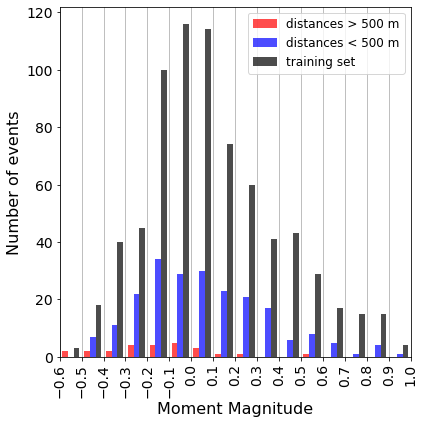

In [18]:
bins = np.arange(-0.6,1.1,0.1)

plt.figure(1,figsize=(6,6))
temp = plt.hist([outliers['Magnitude'], df_Qnet1_good['Magnitude'], df_train['Magnitude']], bins, color=['r','b','k'], alpha=0.7)#plt.hist([df_val['distances_new'], df_test['distances_new']], bins, color=['r','b'], alpha=0.7)
plt.grid(axis='x')
plt.xlabel('Moment Magnitude', fontsize=16)
plt.ylabel('Number of events', fontsize=16)
plt.xticks(bins, fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.xlim([-0.6,1.0])
plt.legend(['distances > 500 m', 'distances < 500 m', 'training set'], loc='upper right',fontsize=12)
plt.tight_layout()
plt.savefig('drive/My Drive/Texas_TL/Figures/hist_magnitudes_outliers.pdf')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


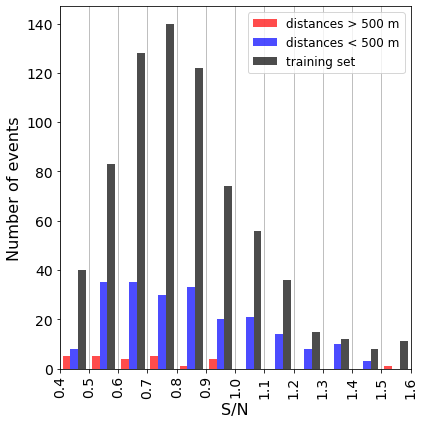

In [26]:
bins = np.arange(0.0,1.7,0.1)

plt.figure(1,figsize=(6,6))
temp = plt.hist([outliers['SNR'], df_Qnet1_good['SNR'], df_train['SNR']], bins, color=['r','b','k'], alpha=0.7)#plt.hist([df_val['distances_new'], df_test['distances_new']], bins, color=['r','b'], alpha=0.7)
plt.grid(axis='x')
plt.xlabel('S/N', fontsize=16)
plt.ylabel('Number of events', fontsize=16)
plt.xticks(bins, fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.xlim([0.4,1.6])
plt.legend(['distances > 500 m', 'distances < 500 m', 'training set'], loc='upper right',fontsize=12)
plt.tight_layout()
plt.savefig('drive/My Drive/Texas_TL/Figures/hist_snr_outliers.pdf')
plt.show()